In [53]:
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syedmuneeb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/syedmuneeb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
train_df = pd.read_csv("data/train.csv")

#### Text Preprocessing

In [5]:
train_df.columns

Index(['review', 'sentiment'], dtype='object')

In [6]:
train_df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
train_df.dropna(axis = 0, how="any", inplace=True)

Punctuation Removal

In [8]:
def punctuation_removal(text):
    punctuations = string.punctuation
    return text.str.replace(fr"([{punctuations}])", repl="", regex=True)

Stop Word Removal

In [9]:
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    output= [i for i in text if i not in stopwords]
    return output

Lemmatization

In [10]:
def lemmatizer(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    return [wordnet_lemmatizer.lemmatize(word) for word in text]

Preprocess Function

In [11]:
def preprocess_text(text):
    #removing punctuations
    text_no_punc = punctuation_removal(text)
    #lowercase
    text_lowercase = text_no_punc.str.lower()
    #tokenization
    text_tokenized = text_lowercase.str.split()
    #stopword removal
    text_no_stop = text_tokenized.apply(lambda x: remove_stopwords(x))
    #lemmatization
    text_lemmatized = text_no_stop.apply(lambda x: lemmatizer(x))
    #list to string
    preprocessed_text = text_lemmatized.apply(lambda x: " ".join(x))
    return preprocessed_text

#### Train Model Pipeline (Preprocessing + BOW + Naive Bayes Classifier)

In [12]:
train_df['preprocessed_reviews'] = preprocess_text(train_df['review'])

In [23]:
tfidf = TfidfVectorizer(ngram_range=(1,2), strip_accents='unicode', sublinear_tf=True)

In [27]:
tfidf_vector = tfidf.fit_transform(train_df['preprocessed_reviews'])

In [31]:
naive_bayes = MultinomialNB()
naive_bayes.fit(tfidf_vector, y=train_df['sentiment'])

MultinomialNB()

In [41]:
classes_mapping = {"positive":1, "negative":0}

In [36]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(tfidf_vector, y=train_df['sentiment'].replace(classes_mapping))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [54]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(tfidf_vector, y=train_df['sentiment'])

KNeighborsClassifier()

In [55]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(tfidf_vector, y=train_df['sentiment'])

RandomForestClassifier()

In [56]:
ada = AdaBoostClassifier()
ada.fit(tfidf_vector, y=train_df['sentiment'])

/opt/homebrew/Caskroom/miniforge/base/envs/sentiment-analysis/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()

In [57]:
# Train Accuracy
nb_predicted_labels = naive_bayes.predict(tfidf_vector)
xgb_predicted_labels = xgb_classifier.predict(tfidf_vector)
knn_predicted_labels = knn_classifier.predict(tfidf_vector)
rf_predicted_labels = random_forest_classifier.predict(tfidf_vector)
ada_predicted_labels = ada.predict(tfidf_vector)

print(f"NB Train Accuracy: {accuracy_score(train_df['sentiment'], nb_predicted_labels)*100}%")
print(f"XGB Train Accuracy: {accuracy_score(train_df['sentiment'].replace(classes_mapping), xgb_predicted_labels)*100}%")
print(f"KNN Train Accuracy: {accuracy_score(train_df['sentiment'], knn_predicted_labels)*100}%")
print(f"RF Train Accuracy: {accuracy_score(train_df['sentiment'], rf_predicted_labels)*100}%")
print(f"ADA Train Accuracy: {accuracy_score(train_df['sentiment'], ada_predicted_labels)*100}%")

NB Train Accuracy: 99.02%
XGB Train Accuracy: 93.82666666666667%
KNN Train Accuracy: 87.87%
RF Train Accuracy: 100.0%
ADA Train Accuracy: 80.51333333333334%


#### Predicting Test Labels

In [43]:
test_df = pd.read_csv("data/test.csv")

In [44]:
test_df['preprocessed_reviews'] = preprocess_text(test_df['review'])

In [45]:
X_test = tfidf.transform(test_df['preprocessed_reviews'])

In [60]:
# Test Accuracy
nb_predicted_labels = naive_bayes.predict(X_test)
xgb_predicted_labels = xgb_classifier.predict(X_test)
knn_predicted_labels = knn_classifier.predict(X_test)
rf_predicted_labels = random_forest_classifier.predict(X_test)
ada_predicted_labels = ada.predict(X_test)

print(f"NB Test Accuracy: {accuracy_score(test_df['sentiment'], nb_predicted_labels)*100}%")
print(f"XGB Test Accuracy: {accuracy_score(test_df['sentiment'].replace(classes_mapping), xgb_predicted_labels)*100}%")
print(f"KNN Test Accuracy: {accuracy_score(test_df['sentiment'], knn_predicted_labels)*100}%")
print(f"RF Test Accuracy: {accuracy_score(test_df['sentiment'], rf_predicted_labels)*100}%")
print(f"ADA Test Accuracy: {accuracy_score(test_df['sentiment'], ada_predicted_labels)*100}%")

NB Test Accuracy: 88.67%
XGB Test Accuracy: 85.695%
KNN Test Accuracy: 80.535%
RF Test Accuracy: 85.715%
ADA Test Accuracy: 80.025%


In [69]:
def confusion_matrix_heatmap(mat, data, title):
    labels = data['sentiment'].unique()
    sns.heatmap(mat.T, square = True, annot=True, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="Blues")
    plt.title(title)
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()

In [70]:
# Confusion Matrix
nb_mat = confusion_matrix(test_df['sentiment'], nb_predicted_labels, normalize= 'true')
xgb_mat = confusion_matrix(test_df['sentiment'].replace(classes_mapping), xgb_predicted_labels, normalize= 'true')
knn_mat = confusion_matrix(test_df['sentiment'], knn_predicted_labels, normalize= 'true')
rf_mat = confusion_matrix(test_df['sentiment'], rf_predicted_labels, normalize= 'true')
ada_mat = confusion_matrix(test_df['sentiment'], ada_predicted_labels, normalize= 'true')

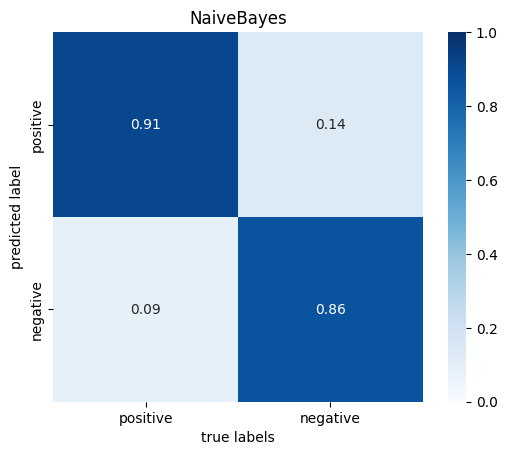

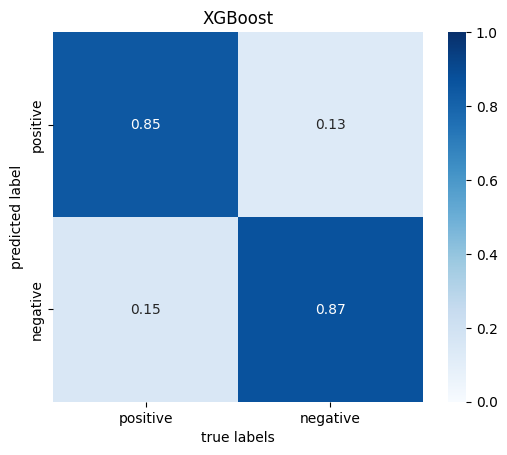

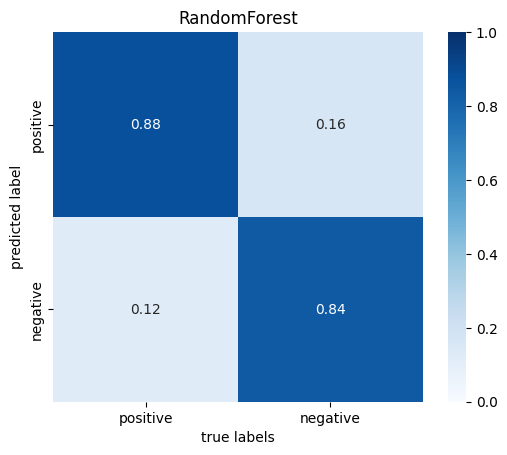

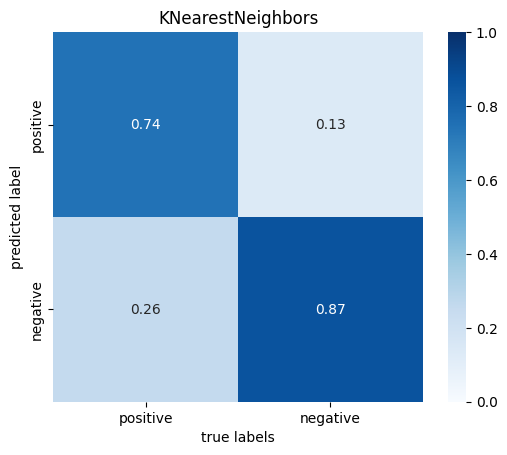

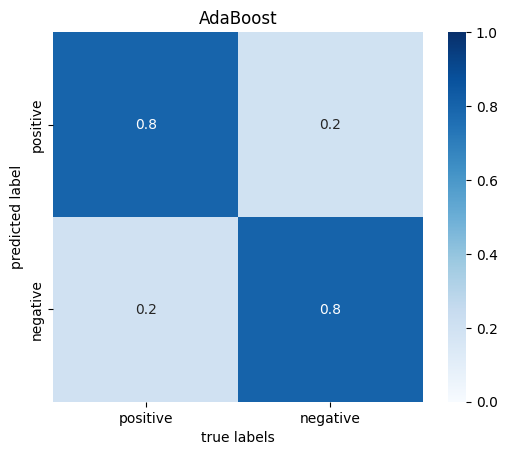

In [71]:
# Confusion Matrix
confusion_matrix_heatmap(nb_mat, test_df, "NaiveBayes")
confusion_matrix_heatmap(xgb_mat, test_df, "XGBoost")
confusion_matrix_heatmap(rf_mat, test_df, "RandomForest")
confusion_matrix_heatmap(knn_mat, test_df, "KNearestNeighbors")
confusion_matrix_heatmap(ada_mat, test_df, "AdaBoost")